Epipolar Geometry implementation. Use superpixels instead of all pixels for the point-matching algorithm.

References:
https://docs.opencv.org/3.2.0/da/de9/tutorial_py_epipolar_geometry.html.

In [3]:
import sys
sys.path.append("../")
import superpixels as sp
from helpers import *
import imageio
from matplotlib import pyplot as plt

def calibrate(glob_path):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    rows = 7
    cols = 7
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((cols * rows, 3), np.float32)
    objp[:, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    import pylab
    import imageio
    images = []
    import glob

    #for i in range(0, len(images), 1):
    #images = ['IMG_20171211_151001.jpg']
    images = glob.glob(glob_path)
    print(images)
    for fname in images:
        img = cv2.imread(fname)
        img = cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #cv2.imshow('img', gray)
        #cv2.waitKey(500)

        print('Processing calibration images')
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
        print(ret)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (cols, rows), corners2, ret)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)

    return  cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


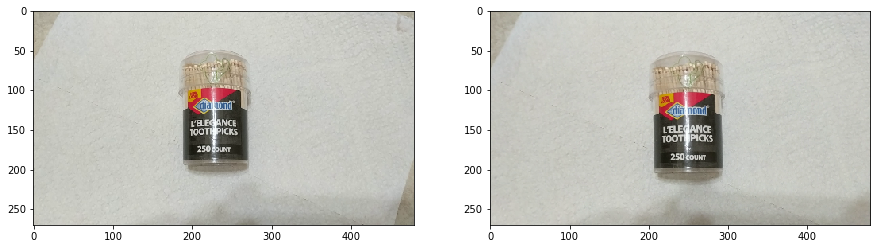

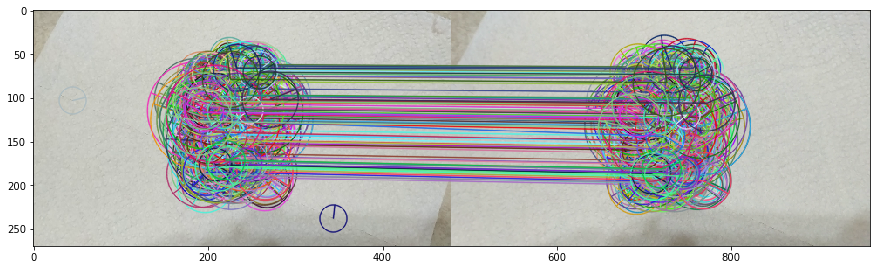

Fundamental Matrix:
 [[  8.59546315e-06   2.88060918e-04  -3.95591107e-02]
 [ -2.72683928e-04  -9.93232085e-06   5.91683715e-02]
 [  3.57593393e-02  -6.55636440e-02   1.00000000e+00]]
pts: (100, 1, 2)


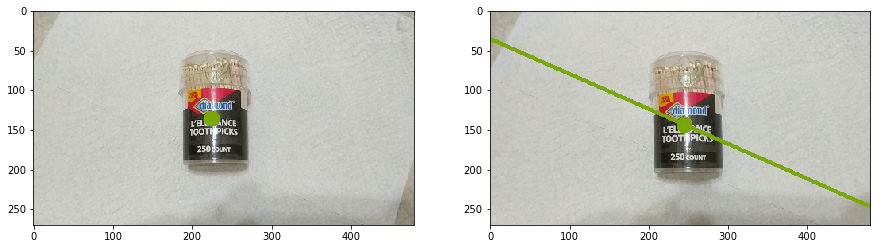

In [4]:
import numpy as np
import cv2

sp.num_superpixels = 100
filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

img1 = get_smaller_image(vid, 0)
img2 = get_smaller_image(vid, 20)

sp_map1 = sp.extract_superpixels(img1)
sp_map2 = sp.extract_superpixels(img2)

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img1)
plt.subplot(222), plt.imshow(img2)
plt.show()

def find_point_matches(img1, img2, K,
                       nfeatures=1000, n_matches=10):
    """ Find point matches between two images.

    Args:
        - img1: Image 1
        - img2: Image 2
        - maps1: Maps of superpixels of image 1.
        - maps2: Maps of superpixels of image 2.
    """
    w = img1.shape[1]
    h = img1.shape[0]
    corners = [[0,0], [0,w-1], [h-1,w-1], [h-1, 0]]
    # Initiate ORB detector
    orb = cv2.ORB_create(scoreType=cv2.ORB_FAST_SCORE, nfeatures=nfeatures)
    # find the keypoints with ORB
    kp1 = orb.detect(img1, None)
    kp2 = orb.detect(img2, None)
    # compute the descriptors with ORB
    kp1, des1 = orb.compute(img1, kp1)
    kp2, des2 = orb.compute(img2, kp2)
    # draw only keypoints location,not size and orientation
    vis = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0), flags=2)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key=lambda x: x.distance)

    img3 = np.zeros_like(img2)
    img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                           matches[:n_matches], img3,
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(15,15))
    plt.imshow(img3)
    plt.show()
    
    focal = K[0,0]
    ppx = K[0,2]
    ppy = K[1,2]
    alignedLeft = {'pt': [], 'des': []}
    alignedRight = {'pt': [], 'des': []}
    leftBackReference = []
    rightBackReference = []
    #Arrange matching points in aligned arrays:
    for i, match in enumerate(matches[:n_matches]):
        qid = match.queryIdx
        tid = match.trainIdx
        #print('qid, tid:', qid, tid)
        alignedLeft['pt'].append(kp1[qid].pt)
        alignedLeft['des'].append(des1[qid,:])
        alignedRight['pt'].append(kp2[tid].pt)
        alignedRight['des'].append(des2[tid,:])
    pts1 = np.array(alignedLeft['pt']).reshape(n_matches, 1, -1).astype(np.float32)
    pts2 = np.array(alignedRight['pt']).reshape(n_matches, 1, -1).astype(np.float32)

    return (pts1, pts2)


def drawlines(img1,img2,lines,pts1,pts2, showlines=True):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    rows = img1.shape[0]
    cols = img1.shape[1]
    #img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    #img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for line,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        #x0,y0 = map(int, [0, -r[2]/r[1] ])
        #x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        x0,y0 = map(int, [0, -line[2] / line[1] ])
        x1,y1 = map(int, [cols, -(line[2] + line[0] * cols) / line[1] ])
        if showlines:
            img1 = cv2.line(img1, (x0,y0), (x1,y1), color,3)
        img1 = cv2.circle(img1,tuple(pt1[0]),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2[0]),10,color,-1)
    return img1,img2

# Calibration needs only be done once.
# ret, mtx, dist, rvecs, tvecs = calibrate('../../calib/*.jpg')
# print(mtx)
mtx = np.array([[ 633.14676506,    0.,            407.2286842 ],
                [   0.,            627.07243572,  281.21216339],
                [   0.,            0.,            1.        ]])

pts1, pts2 = find_point_matches(img1, img2, mtx, n_matches=100)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print("Fundamental Matrix:\n", F)
print("pts:",pts2.shape)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)

numlines = 1
img5, img6 = drawlines(img1, img2, lines1[0:numlines], pts1[0:numlines], pts2[0:numlines], showlines=False)
img3, img4 = drawlines(img2, img1, lines2[0:numlines], pts2[0:numlines], pts1[0:numlines])

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img5)
plt.subplot(222), plt.imshow(img3)
plt.show()

Now, we use epilines to get overlapping superpixels.

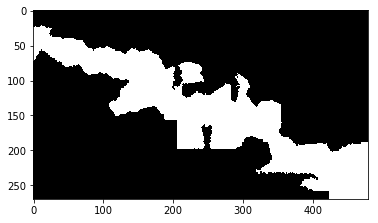

In [5]:
import epipolar as ep

line = lines2[0]

def get_superpixels_on_epiline(sp_map, line): 
    sids = []
    for x in range(sp_map.shape[1]):
        y = -(line[2] + line[0] * x) / line[1]
        y = int(round(y))
        if y >= 0 and y < sp_map.shape[0]:
            sids.append(sp_map[y, x])
    sids = list(set(sids))
    return sids
    
sids = get_superpixels_on_epiline(sp_map2, line)
himg = sp.highlight_superpixels(sp_map2, sids)
    
plt.imshow(himg, cmap="gray")
plt.show()